<a href="https://colab.research.google.com/github/tomonari-masada/course2021-sml/blob/main/05_nearest_neighbors_2_(in_class).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. k近傍法（続）
* 今回は、近傍の個数kの値をどのようにして決めるかを考える。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 5.1 準備

### 5.1.1 インポート

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [ ]:
#import warnings
#warnings.filterwarnings('ignore')

### 5.1.2 データファイルのアップロード

* `lifesat.csv`をアップロードする。

In [ ]:
from google.colab import files
files.upload()

### 5.1.3 データファイルの読み込み
* 今回は、ファイルを読み込むときに、国名をインデックスに設定してしまう。
 * index_col引数を使っている。

In [3]:
df = pd.read_csv('/content/drive/MyDrive/2021Courses/SML/lifesat.csv', index_col=0)

In [4]:
df

,GDP per capita,Life satisfaction
Country,,
Russia,9054.914,6.0
Turkey,9437.372,5.6
Hungary,12239.894,4.9
Poland,12495.334,5.8
Slovak Republic,15991.736,6.1
Estonia,17288.083,5.6
Greece,18064.288,4.8
Portugal,19121.592,5.1
Slovenia,20732.482,5.7


In [5]:
df.describe()

,GDP per capita,Life satisfaction
count,29.000000,29.000000
mean,33391.749138,6.493103
std,14650.076056,0.839613
min,9054.914000,4.800000
25%,19121.592000,5.800000
50%,37044.891000,6.800000
75%,43724.031000,7.300000
max,55805.204000,7.500000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, Russia to United States
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GDP per capita     29 non-null     float64
 1   Life satisfaction  29 non-null     float64
dtypes: float64(2)
memory usage: 696.0+ bytes


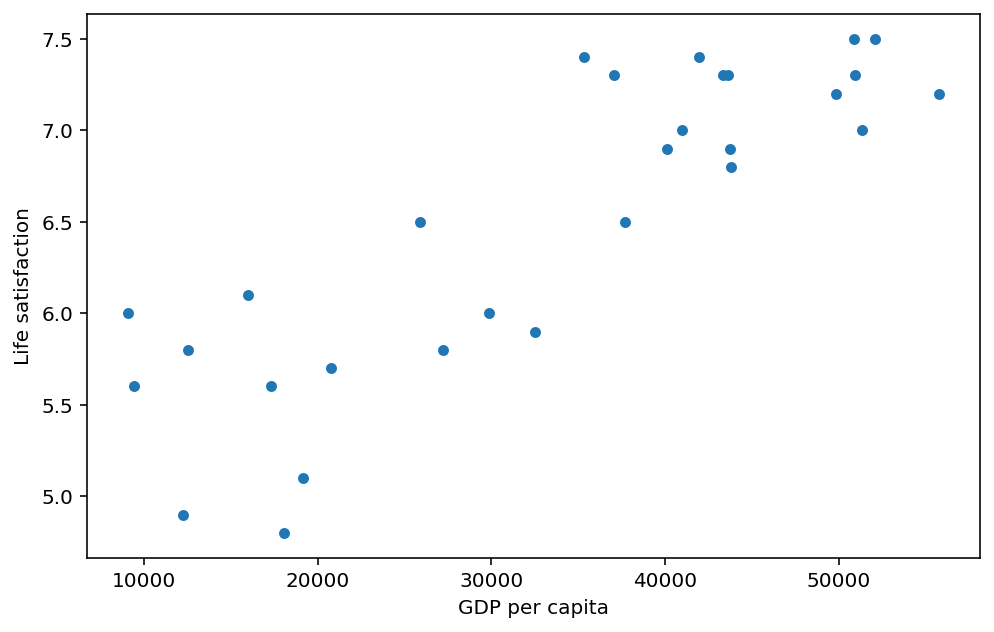

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df.plot(kind='scatter', x='GDP per capita', y='Life satisfaction', ax=ax)

## 5.2 訓練データ/検証データ/テストデータ


### 5.2.1 問題設定
- 一人当たりのGDPから生活満足度を予測したい。
- 今回も、日本の生活満足度を予測するという設定。
- 一人当たりのGDPを使って日本の近傍を見つけ、その近傍の生活満足度を予測に利用する。
- 予測の良し悪しは、実際の値との差の絶対値で評価する。

### 5.2.2 テストデータ

* 今回も、日本の生活満足度を予測する、という問題を考える。
* 最終的にはそれについて予測をおこないたいデータを、テストデータと呼ぶ。
* よって、日本のデータが、テストデータになる。


### 5.2.3 検証データ

* 今回は、何らかの方法で、最適な近傍の個数kを求めたい。
* しかし、日本の生活満足度を予測させて、その予測誤差を見ながらkを決めるのでは、カンニングしていることになる。
* 日本の生活満足度の正解の値を見ずに、kを決める方法はないだろうか。


* そこで、テストデータ以外のデータを使って、予測問題を解く。
 * テストデータ以外については、正解、つまり、生活満足度は、分かっているとしてよい。
* テストデータ以外のデータの中から、国を一つ選んで（例えば韓国）、その国について最も良い予測を与えるkを調べる。
* このとき選ばれた国のデータを、検証データと呼ぶ。
 * 本当に予測をしたいデータではないが、検証validationのためにそれについて予測をおこなうデータ。
* 検証データ上で予測を行うことで得られた最適なkの値を、日本についての予測で使う。
 * テストデータでも検証データでもないデータを、訓練データと呼ぶ。

## 5.3 検証データを使った最適なkの決定
* ここでは、韓国を検証データとして使う。
* 日本はそもそも除外しておく。
* 日本以外のデータを使って、韓国の生活満足度を予測してみる。
* そして、最も良い予測値を与えるkがいくらか、調べる。

In [8]:
from sklearn.neighbors import KNeighborsRegressor

In [9]:
neigh = KNeighborsRegressor(n_neighbors=3)

In [11]:
df2 = df[df.index != 'Japan'] # テストデータはのけておく

In [12]:
df2

,GDP per capita,Life satisfaction
Country,,
Russia,9054.914,6.0
Turkey,9437.372,5.6
Hungary,12239.894,4.9
Poland,12495.334,5.8
Slovak Republic,15991.736,6.1
Estonia,17288.083,5.6
Greece,18064.288,4.8
Portugal,19121.592,5.1
Slovenia,20732.482,5.7


In [18]:
df_train = df2[df2.index != 'Korea']
df_valid = df2.loc['Korea']

In [37]:
df_valid

GDP per capita       27195.197
Life satisfaction        5.800
Name: Korea, dtype: float64

### 5.3.1 演習

* 演習問題5-1：日本を除去したデータフレームを作ろう。

In [ ]:
df2 = df[df.index != 'Japan'] # テストデータはのけておく

* 演習問題5-2：前回と同じ方法で、韓国の生活満足度を予測し、最も良い予測値を与えるkを調べよう。

In [22]:
neigh = KNeighborsRegressor(n_neighbors=3)

In [27]:
X_train = df_train['GDP per capita'].to_numpy()

In [29]:
X_train

array([ 9054.914,  9437.372, 12239.894, 12495.334, 15991.736, 17288.083,
       18064.288, 19121.592, 20732.482, 25864.721, 29866.581, 35343.336,
       37044.891, 37675.006, 40106.632, 40996.511, 41973.988, 43331.961,
       43603.115, 43724.031, 43770.688, 49866.266, 50854.583, 50961.865,
       51350.744, 52114.165, 55805.204])

In [28]:
y_train = df_train['Life satisfaction'].to_numpy()

In [30]:
y_train

array([6. , 5.6, 4.9, 5.8, 6.1, 5.6, 4.8, 5.1, 5.7, 6.5, 6. , 7.4, 7.3,
       6.5, 6.9, 7. , 7.4, 7.3, 7.3, 6.9, 6.8, 7.2, 7.5, 7.3, 7. , 7.5,
       7.2])

In [34]:
X_train = X_train.reshape(-1, 1)

In [35]:
X_train

array([[ 9054.914],
       [ 9437.372],
       [12239.894],
       [12495.334],
       [15991.736],
       [17288.083],
       [18064.288],
       [19121.592],
       [20732.482],
       [25864.721],
       [29866.581],
       [35343.336],
       [37044.891],
       [37675.006],
       [40106.632],
       [40996.511],
       [41973.988],
       [43331.961],
       [43603.115],
       [43724.031],
       [43770.688],
       [49866.266],
       [50854.583],
       [50961.865],
       [51350.744],
       [52114.165],
       [55805.204]])

In [36]:
neigh.fit(X_train, y_train) # 予測器くんにデータを渡す

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [38]:
df_valid

GDP per capita       27195.197
Life satisfaction        5.800
Name: Korea, dtype: float64

In [39]:
df_valid['GDP per capita']

27195.197

In [46]:
prediction = neigh.predict([[df_valid['GDP per capita']]])[0]

In [47]:
prediction

6.066666666666666

In [45]:
abs(prediction - df_valid['Life satisfaction']) # k=3の場合

0.2666666666666666

* 演習問題5-3：こうして調べたkを使って、元のデータフレームに戻って、日本の生活満足度を予測し、予測誤差を求めよう。

## 5.4 ‎leave-one-out交差検証 (1)
* 上では、韓国を検証データとして使った。
* しかし、韓国以外の国を検証データとしても構わないはずである。
* そこで、日本以外の国について、その一つ一つを検証データとした場合の、それぞれの最適なkの値を求めてみる。

### 5.4.1 演習

* 演習問題5-4：国名が引数として与えられると（もちろん日本は除外する）、それを検証データとして予測を実行し、最適なkを返すような関数を、実装してみよう。
 * つまり、上で韓国について行ったことと、同じことを、（日本を除く）他の国についても実行するような関数を書く。

* 上で実装した関数を使って、各国について得られたkを、どのように使えば、最適なkを求められるか、考えてみよう。
 * 例えば、各国について得られたkの平均をとることが考えられる。これは良い方法と言えるだろうか？

## 5.5 ‎leave-one-out交差検証 (2)
* 上では、日本以外の国を、一つずつ、順番に検証データとして、最適なkを求めた。
* しかし、こうして国ごとに求められたkを、どうやってまとめあげるのか、疑問が残った。
 * それらkの平均をとる、という方法は、何かおかしい感じがする。
 * 最頻値の方が、まだましであろう。
* 最適なkを決める、もっと良い方法はないだろうか？

### 5.5.1 演習

* 演習問題5-5：上で作った関数を少し変えて、k=1,2,3,...と、kを変えたときに、それぞれの場合で予測誤差がいくらになるかを表す配列を返すように、書き換えてみよう。

* 演習問題5-6：縦が国名、横がkの値の表をデータフレームを作り、特定の国を検証データとしたとき、特定のkを使った場合に、生活満足度の予測誤差がいくらになるかの数値で埋めてみよう。

* 演習問題5-7：上で作った表で、それぞれのkの値について、予測誤差の平均値を求めてみよう。

* 演習問題5-8：上で求めた平均値で見て、最適なkの値は、いくらになるか。

* 演習問題5-9：こうして求めた最適なkを使って、元に戻って、日本の生活満足度の予測をしてみよう。

## 5.6 多変量を使った予測

* 今回使ったデータは、元々は、複数の説明変数を含むデータだった。
* そのうち、今回は、一人あたりのGDPだけを、説明変数として使った。

* そこで、元の、複数の説明変数があるデータを使って、これまでと同じことをしてみよう。
* つまり、leave-one-out交差検証で最適なkを求め、そのkを使って、日本の生活満足度を予測してみよう。
* 国どうしの距離を計算するには、どうすればいいか、考えてみよう。

### 5.6.1 データファイルのアップロード
* `lifesat_extended.csv`というファイルをアップロードする。

In [ ]:
from google.colab import files
files.upload()

In [ ]:
df_multi = pd.read_csv('lifesat_extended.csv', index_col=0)

In [ ]:
df_multi.info()

In [ ]:
df_multi.describe()

## 5.7 課題5
* leave-one-out交差検証で最適なkを求め、そのkを使って、日本の生活満足度を予測してみよう。